In [1]:
using QuadGK, LaTeXStrings, Plots, LinearAlgebra, BenchmarkTools;
using DataFrames, CSV,Interpolations,Suppressor;
import JLD,ForwardDiff;
using Plots.PlotMeasures;

In [2]:
gr(frame=:box,size=(400, 300));

In [3]:
const unit = 1.0e-3;
const mpic = 139.57018unit; const mpi0 = 134.9766unit;
const meta = 547.862unit; const mkc = 493.677unit; const mk0 = 497.614unit;
const mpi = (2mpic + mpi0)/3; const mk = (mkc + mk0)/2;
const mπ=mpi;
const mJψ=3.0969;

In [4]:
# redefine sqrt so that its cut is along the positive x axis
function xsqrt(x)
    imag(x) >= 0 ? sqrt(x + 0im) : -sqrt(x - 0im)
end
λ(x, y, z) = x^2 + y^2 + z^2 - 2 * x * y - 2 * x * z - 2 * y * z;

# Load data and interpolation

In [5]:
df_ps_pipi_black = sort(DataFrame(CSV.File("./data/ps_pipi_black.csv")));
df_ps_pipi_blue = sort(DataFrame(CSV.File("./data/ps_pipi_blue.csv")));
df_ps_pipi_green = sort(DataFrame(CSV.File("./data/ps_pipi_green.csv")));
df_ps_pipi_red = sort(DataFrame(CSV.File("./data/ps_pipi_red.csv")));

In [6]:
inte_ps_pipi_black = LinearInterpolation(collect(df_ps_pipi_black.Sqrts), collect(df_ps_pipi_black.delta));
inte_ps_pipi_blue = LinearInterpolation(collect(df_ps_pipi_blue.Sqrts), collect(df_ps_pipi_blue.delta));
inte_ps_pipi_green = LinearInterpolation(collect(df_ps_pipi_green.Sqrts), collect(df_ps_pipi_green.delta));
inte_ps_pipi_red = LinearInterpolation(collect(df_ps_pipi_red.Sqrts), collect(df_ps_pipi_red.delta));

In [7]:
inte_ps_pipi_black_s(s)=s<=4*mpi^2 ? 0.0 : inte_ps_pipi_black(sqrt(s))/180*π
inte_ps_pipi_blue_s(s)=s<=4*mpi^2 ? 0.0 : inte_ps_pipi_blue(sqrt(s))/180*π
inte_ps_pipi_green_s(s)=s<=4*mpi^2 ? 0.0 : inte_ps_pipi_green(sqrt(s))/180*π
inte_ps_pipi_red_s(s)=s<=4*mpi^2 ? 0.0 : inte_ps_pipi_red(sqrt(s))/180*π

inte_ps_pipi_red_s (generic function with 1 method)

In [8]:
function phase_pipi_black(s; sth=4*mpi^2, scut=1.85^2)
    if s < sth
        return 0.0
    elseif sth <= s && s <= scut
        return inte_ps_pipi_black_s(s)
    end
    α=3*(π-inte_ps_pipi_black_s(scut))^2/(2*scut*ForwardDiff.derivative(s -> inte_ps_pipi_black_s(s), scut))
    β=-1+3*(π-inte_ps_pipi_black_s(scut))/(2*scut*ForwardDiff.derivative(s -> inte_ps_pipi_black_s(s), scut))
    return π-α/(β+(s/scut)^(3/2))
end

function phase_pipi_blue(s; sth=4*mpi^2, scut=1.85^2)
    if s < sth
        return 0.0
    elseif sth <= s && s <= scut
        return inte_ps_pipi_blue_s(s)
    end
    α=3*(π-inte_ps_pipi_blue_s(scut))^2/(2*scut*ForwardDiff.derivative(s -> inte_ps_pipi_blue_s(s), scut))
    β=-1+3*(π-inte_ps_pipi_blue_s(scut))/(2*scut*ForwardDiff.derivative(s -> inte_ps_pipi_blue_s(s), scut))
    return π-α/(β+(s/scut)^(3/2))
end

function phase_pipi_green(s; sth=4*mpi^2, scut=1.85^2)
    if s < sth
        return 0.0
    elseif sth <= s && s <= scut
        return inte_ps_pipi_green_s(s)
    end
    α=3*(π-inte_ps_pipi_green_s(scut))^2/(2*scut*ForwardDiff.derivative(s -> inte_ps_pipi_green_s(s), scut))
    β=-1+3*(π-inte_ps_pipi_green_s(scut))/(2*scut*ForwardDiff.derivative(s -> inte_ps_pipi_green_s(s), scut))
    return π-α/(β+(s/scut)^(3/2))
end
function phase_pipi_red(s; sth=4*mpi^2, scut=1.85^2)
    if s < sth
        return 0.0
    elseif sth <= s && s <= scut
        return inte_ps_pipi_red_s(s)
    end
    α=3*(π-inte_ps_pipi_red_s(scut))^2/(2*scut*ForwardDiff.derivative(s -> inte_ps_pipi_red_s(s), scut))
    β=-1+3*(π-inte_ps_pipi_red_s(scut))/(2*scut*ForwardDiff.derivative(s -> inte_ps_pipi_red_s(s), scut))
    return π-α/(β+(s/scut)^(3/2))
end

phase_pipi_red (generic function with 1 method)

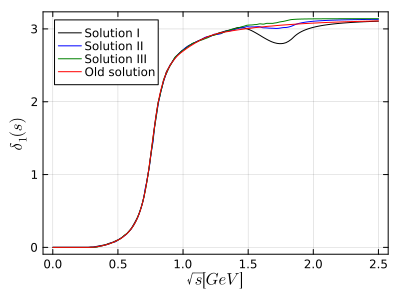

In [9]:
plot(0.0:0.01:2.5,e->phase_pipi_black(e^2),lc=:black,label="Solution I",xlabel=L"\sqrt{s}[GeV]",ylabel=L"\delta_1(s)")
plot!(0.0:0.01:2.5,e->phase_pipi_blue(e^2),lc=:blue,label="Solution II")
plot!(0.0:0.01:2.5,e->phase_pipi_green(e^2),lc=:green,label="Solution III")
plot!(0.0:0.01:2.5,e->phase_pipi_red(e^2),lc=:red,label="Old solution")

In [10]:
function dispersion_integral(f, x, sth; nsub=1)  # these dispersion relation are actually subtracting at s=0
    iϵ = 1e-8im
    res = 0.0im
    if nsub == 1
        integrand1(x′) = f(x′) / (x′ * (x′ - x - iϵ))
        res = quadgk(integrand1, sth, Inf)[1] / π * x
    elseif nsub == 0
        integrand(x′) = f(x′) / (x′ - x - iϵ)
        res = quadgk(integrand, sth, Inf)[1] / π
    end
    return res
end

function Omnes_complex(f, x, sth)
    exp(dispersion_integral(f, x, sth))
end

Omnes_complex (generic function with 1 method)

In [11]:
Ω1_black(s)=Omnes_complex(phase_pipi_black,s,4*mpi^2)
Ω1_blue(s)=Omnes_complex(phase_pipi_blue,s,4*mpi^2)
Ω1_green(s)=Omnes_complex(phase_pipi_green,s,4*mpi^2)
Ω1_red(s)=Omnes_complex(phase_pipi_red,s,4*mpi^2)
Ω1_all(s;ps=phase_pipi_black)=Omnes_complex(ps,s,4*mpi^2)

Ω1_all (generic function with 1 method)

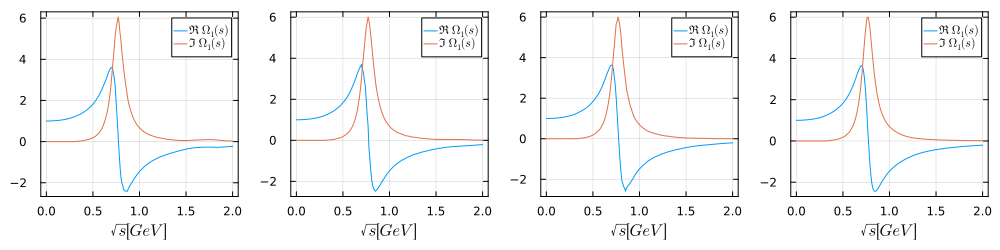

In [12]:
let
    Ev=0.0:0.01:2.0
    resv1=Ω1_black.(Ev .^2)
    resv2=Ω1_blue.(Ev .^2)
    resv3=Ω1_green.(Ev .^2)
    resv4=Ω1_red.(Ev .^2)
    plt1=plot(Ev,real.(resv1),xlabel=L"\sqrt{s}[GeV]",label=L"\Re\ \Omega_1(s)",bottom_margin=7mm)
    plot!(Ev,imag.(resv1),label=L"\Im\ \Omega_1(s)")
    plt2=plot(Ev,real.(resv2),xlabel=L"\sqrt{s}[GeV]",label=L"\Re\ \Omega_1(s)")
    plot!(Ev,imag.(resv2),label=L"\Im\ \Omega_1(s)")
    plt3=plot(Ev,real.(resv3),xlabel=L"\sqrt{s}[GeV]",label=L"\Re\ \Omega_1(s)")
    plot!(Ev,imag.(resv3),label=L"\Im\ \Omega_1(s)")
    plt4=plot(Ev,real.(resv4),xlabel=L"\sqrt{s}[GeV]",label=L"\Re\ \Omega_1(s)")
    plot!(Ev,imag.(resv4),label=L"\Im\ \Omega_1(s)")
    plot(plt1,plt2,plt3,plt4,layout=(1,4),size=(1000,250))
end

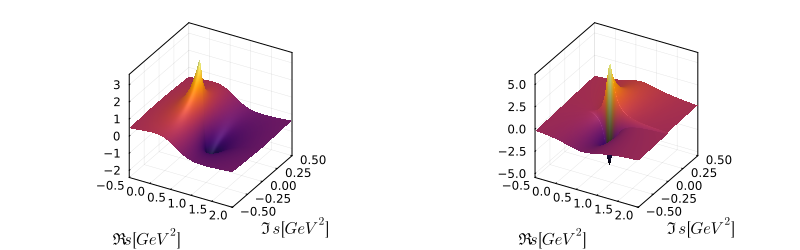

In [13]:
let Resv=-0.5:0.01:2.0,Imsv=-0.5:0.01:0.5
    res_mat=[Ω1_black(x+im*y) for y in Imsv,x in Resv]
    plot(surface(Resv,Imsv,real.(res_mat),xlabel=L"\Re s[GeV^2]",ylabel=L"\Im s[GeV^2]",legend=false),
        surface(Resv,Imsv,imag.(res_mat),xlabel=L"\Re s[GeV^2]",ylabel=L"\Im s[GeV^2]",legend=false),layout=(1,2),size=(800,250))
end

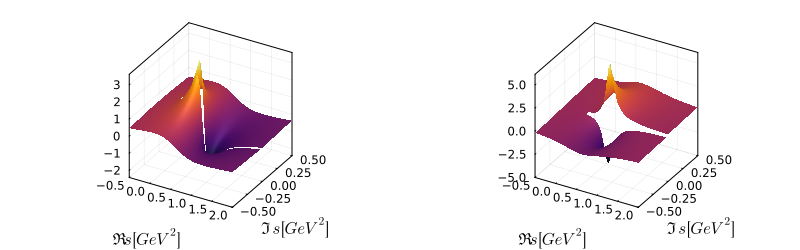

In [14]:
let Resv=-0.5:0.01:2.0,Imsv=-0.5:0.01:0.5
    # set value on the lower rim above the threshold to NaN so that the plot shows the cut
    res_mat=[(x>4*mpi^2&&y≈-0.01) ? NaN+im*NaN : Ω1_black(x+im*y) for y in Imsv,x in Resv]
    plot(surface(Resv,Imsv,real.(res_mat),xlabel=L"\Re s[GeV^2]",ylabel=L"\Im s[GeV^2]",legend=false),
        surface(Resv,Imsv,imag.(res_mat),xlabel=L"\Re s[GeV^2]",ylabel=L"\Im s[GeV^2]",legend=false),layout=(1,2),size=(800,250))
end

In [12]:
sinδ_absΩ(s;ps=phase_pipi_black)=sin(ps(s))/abs(Ω1_all(s;ps=ps))

sinδ_absΩ (generic function with 1 method)

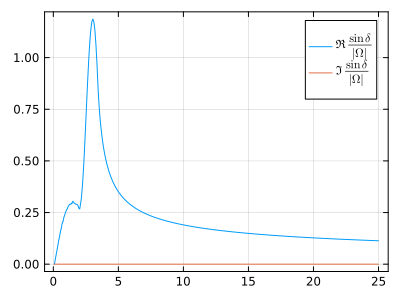

In [16]:
let sv=collect(4*mpi^2:0.01:5^2)
    resv=sinδ_absΩ.(sv;ps=phase_pipi_black)
    plot(sv,real.(resv),label=L"\Re\frac{\sin\delta}{|\Omega|}")
    plot!(sv,imag.(resv),label=L"\Im\frac{\sin\delta}{|\Omega|}")
end

# Solve the KT equation

## analytical continuation of mandelstam limits

In [13]:
function κs(s)
    res = zero(ComplexF64)
    if 4*mpi^2 <= s && s < (mJψ - mpi)^2
        res=√abs(λ(s, mπ^2, mπ^2)) / s * √(abs(λ(s, mJψ^2, mπ^2)))
    elseif (mJψ - mpi)^2 <= s && s < (mJψ + mpi)^2
        res=im*√abs(λ(s, mπ^2, mπ^2)) / s * √(abs(λ(s, mJψ^2, mπ^2)))
    elseif s >= (mJψ + mpi)^2
        res=(-1)*√abs(λ(s, mπ^2, mπ^2)) / s * √(abs(λ(s, mJψ^2, mπ^2)))
    end
    return res 
end
function splus(s; ϵ=1.0e-7)
    Σ0 = mJψ^2 + 3*mπ^2 
    res = 0.0im

    if 4*mpi^2 <= s && s < (mJψ - mpi)^2
        res = 1 / 2 * (Σ0 - s + √abs(λ(s, mπ^2, mπ^2)) / s * √(abs(λ(s, mJψ^2, mπ^2)))) + im * ϵ
    elseif (mJψ - mpi)^2 <= s && s < (mJψ + mpi)^2
        res = 1 / 2 * (Σ0 - s + im * √abs(λ(s, mπ^2, mπ^2)) / s * √(abs(λ(s, mJψ^2, mπ^2)))) + im * ϵ
    elseif s >= (mJψ + mpi)^2
        res = 1 / 2 * (Σ0 - s - √abs(λ(s, mπ^2, mπ^2)) / s * √(abs(λ(s, mJψ^2, mπ^2)))) + im * ϵ
    end

    return res
end

function sminus(s; ϵ=1.0e-7)
    Σ0 = mJψ^2 + 3*mπ^2
    res = 0.0im

    if 4*mpi^2 <= s && s < (mJψ^2 - mpi^2)/2
        res = 1 / 2 * (Σ0 - s - √abs(λ(s, mπ^2, mπ^2)) / s * √(abs(λ(s, mJψ^2, mπ^2)))) + im * ϵ
    elseif (mJψ^2 - mpi^2)/2 <= s && s < (mJψ - mpi)^2
        res = 1 / 2 * (Σ0 - s - √abs(λ(s, mπ^2, mπ^2)) / s * √(abs(λ(s, mJψ^2, mπ^2)))) - im * ϵ
    elseif (mJψ - mpi)^2 <= s && s < (mJψ + mpi)^2
        res = 1 / 2 * (Σ0 - s - im * √abs(λ(s, mπ^2, mπ^2)) / s * √(abs(λ(s, mJψ^2, mπ^2)))) - im * ϵ
    elseif s >= (mJψ + mpi)^2
        res = 1 / 2 * (Σ0 - s + √abs(λ(s, mπ^2, mπ^2)) / s * √(abs(λ(s, mJψ^2, mπ^2)))) - im * ϵ
    end
end

sminus (generic function with 1 method)

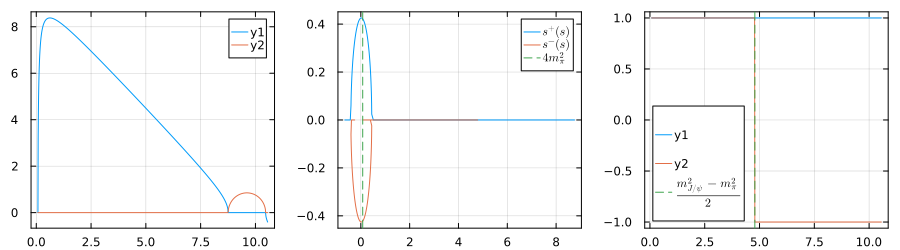

In [18]:
let sv=collect(4*mpi^2:0.01:(mJψ+mpi)^2+0.1)
    plt1=plot(sv,s->real(κs(s)))
    plot!(sv,s->imag(κs(s)))
    
    resv1,resv2=splus.(sv),sminus.(sv)
    #plot the trajectory
    plt2=plot(real.(resv1),imag.(resv1),label=L"s^{+}(s)")
    plot!(real.(resv2),imag.(resv2),label=L"s^{-}(s)")
    vline!([4*mpi^2],ls=:dash,label=L"4m_{\pi}^2")
    #ensure the sign of the imaginary part
    plt3=plot(sv,sign.(imag.(resv1)))
    plot!(sv,sign.(imag.(resv2)))
    vline!([(mJψ^2-mpi^2)/2],ls=:dash,label=L"\frac{m_{J/\psi}^2-m_{\pi}^2}{2}")
    
    plot(plt1,plt2,plt3,layout=(1,3),size=(900,250))
end

## solve by iteration

In [14]:
import NumericalIntegration,JLD;

In [15]:
hfunc(t,a,b,c)=(t-a)*(c-t)/(b-a)/(c-b);
function Gfunc(s,a,b,c;ϵ=1.0e-8)
    ω,ω1,ω3=xsqrt(b-s-im*ϵ),xsqrt(b-a),xsqrt(b-c-im*ϵ)
    2*hfunc(s,a,b,c)/ω^3*(atanh(ω1/ω)-atanh(ω3/ω))-2*(1/ω1-1/ω3)*(1/ω^2-1/ω1/ω3)
end

Gfunc (generic function with 1 method)

In [16]:
xxxwww=gauss(149,0,1);
xxx=vcat(0.0,xxxwww[1]);
lenx=length(xxx);
function getintegralpoints(endpoints;xxx=xxx)
    g(z1,z2)=broadcast(x->z1*(1-x)+z2*x,xxx)
    resvec=[]
    for i in 1:length(endpoints)-1
        append!(resvec,g(endpoints[i],endpoints[i+1])...)
    end
    resvec
end

getintegralpoints (generic function with 1 method)

In [17]:
(mJψ-mpi),(mJψ+mpi)

(2.9588610133333337, 3.2349389866666667)

In [18]:
const spath_vec=getintegralpoints([4*mpi^2,0.5,1.0,1.5,2.5,2.5^2,(mJψ-mpi)^2,(mJψ+mpi)^2,5.0^2]); # cutoff=5.0^2

In [19]:
lens=length(spath_vec)

1200

In [20]:
spath_curve=vcat(reverse(sminus.(spath_vec)),splus.(spath_vec));

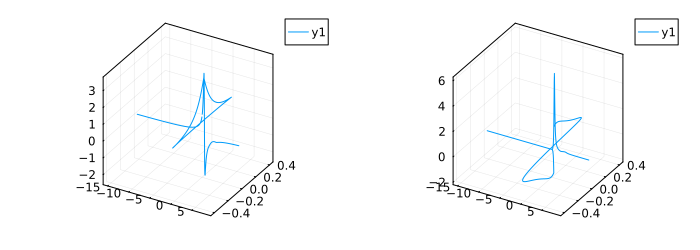

In [26]:
let
    resv=Ω1_all.(spath_curve;ps=phase_pipi_black)
    plt1=plot(real.(spath_curve),imag.(spath_curve),real.(resv))
    plt2=plot(real.(spath_curve),imag.(spath_curve),imag.(resv))
    plot(plt1,plt2,layout=(1,2),size=(700,250))
end

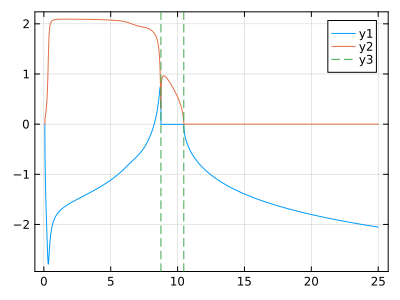

In [27]:
let
    Ω1_arr=Ω1_all.(spath_curve;ps=phase_pipi_black)
    resv=zeros(ComplexF64,lens)
    for i in 1:lens
        resv[i]=NumericalIntegration.integrate(spath_curve[lens-i+1:lens+i],Ω1_arr[lens-i+1:lens+i])
    end
    plot(spath_vec,real.(resv))
    plot!(spath_vec,imag.(resv))
    vline!([(mJψ-mpi)^2,(mJψ+mpi)^2],ls=:dash)
end

In [21]:
sinδ_absΩ_arr=sinδ_absΩ.(spath_vec;ps=phase_pipi_black);

In [22]:
Ω1_arr_curve=Ω1_all.(spath_curve;ps=phase_pipi_black);

In [23]:
function disperfunc(s;nsub=1,Ft_arr=Ftilde_arr,ϵ=1.0e-8,rtol=1e-3)
    s1,s2,s3,s4,scut=(4*mpi^2+(mJψ-mpi)^2)/2,(mJψ-mpi)^2,((mJψ-mpi)^2+(mJψ+mpi)^2)/2,(mJψ+mpi)^2,5.0^2
    kerfunc=LinearInterpolation(spath_vec,(sinδ_absΩ_arr .*Ft_arr),extrapolation_bc=Line())

    res=zero(ComplexF64)
    Ω1_s=Ω1_all(s)
    
    # attributions from the first part of integral
    res+=Ω1_s*s^nsub/π*quadgk(x->1/x^nsub*kerfunc(x)/κs(x)^3/(x-s-im*ϵ),4*mpi^2,s1;rtol=rtol)[1]

    # attributions from the second part of integral
    Hfunc=LinearInterpolation(spath_vec,(@. 1/spath_vec^nsub*sinδ_absΩ_arr*Ft_arr/(sqrt(spath_vec+im*ϵ)*sqrt(spath_vec-4*mpi^2+im*ϵ)*sqrt((mJψ+mpi)^2-spath_vec+im*ϵ))^3),extrapolation_bc=Line())
    H_s2=Hfunc(s2)
    spath_sub=spath_vec[s1-0.1 .<spath_vec .<s3+0.1]
    func_derivative=LinearInterpolation(spath_sub,broadcast(x->(Hfunc(x)-hfunc(x,s1,s2,s3)*H_s2)/((mJψ-mpi)^2-x+im*ϵ),spath_sub),extrapolation_bc=Line())
    res+=Ω1_s*s^nsub/π*quadgk(x->func_derivative(x)/sqrt((mJψ-mpi)^2-x+im*ϵ)/(x-s-im*ϵ),s1,s3;rtol=rtol)[1]
    res+=Ω1_s*s^nsub/π*H_s2*Gfunc(s,s1,s2,s3)

    # attributions from the third part of integral
    Hfunc1=LinearInterpolation(spath_vec,(@. 1/spath_vec^nsub*sinδ_absΩ_arr*Ft_arr/(sqrt(spath_vec+im*ϵ)*sqrt(spath_vec-4*mpi^2+im*ϵ)*sqrt((mJψ-mpi)^2-spath_vec+im*ϵ))^3),extrapolation_bc=Line())
    H1_s4=Hfunc1(s4)
    spath_sub1=spath_vec[s3-0.1 .<spath_vec]
    func_derivative1=LinearInterpolation(spath_sub1,broadcast(x->(Hfunc1(x)-hfunc(x,s3,s4,scut)*H1_s4)/((mJψ+mpi)^2-x+im*ϵ),spath_sub1),extrapolation_bc=Line())
    res+=Ω1_s*s^nsub/π*quadgk(x->func_derivative1(x)/sqrt((mJψ+mpi)^2-x+im*ϵ)/(x-s-im*ϵ),s3,scut;rtol=rtol)[1]
    res+=Ω1_s*s^nsub/π*H1_s4*Gfunc(s,s3,s4,scut)
    
    return res
end

disperfunc (generic function with 1 method)

In [24]:
function KT_iteration!(;nsub=1,Ft_arr_init=Ftilde_arr_initial,Ft_arr=Ftilde_arr,ϵ=1.0e-8,rtol=1e-3)
    s1,s2,s3,s4,scut=(4*mpi^2+(mJψ-mpi)^2)/2,(mJψ-mpi)^2,((mJψ-mpi)^2+(mJψ+mpi)^2)/2,(mJψ+mpi)^2,5.0^2
    kerfunc=LinearInterpolation(spath_vec,(sinδ_absΩ_arr .*Ft_arr),extrapolation_bc=Line())

    # attributions from the first part of integral
    print("Processing the first integral...")
    res_arr1=@. Ω1_arr_curve*spath_curve^nsub/π*quadgk(x->(@. 1/(x-spath_curve-im*ϵ)) .*1/x^nsub*kerfunc(x)/κs(x)^3,4*mpi^2,s1;rtol=rtol)[1]
    
    # attributions from the second part of integral
    print("Processing the second integral...")
    Hfunc=LinearInterpolation(spath_vec,(@. 1/spath_vec^nsub*sinδ_absΩ_arr*Ft_arr/(sqrt(spath_vec+im*ϵ)*sqrt(spath_vec-4*mpi^2+im*ϵ)*sqrt((mJψ+mpi)^2-spath_vec+im*ϵ))^3),extrapolation_bc=Line())
    H_s2=Hfunc(s2)
    spath_sub=spath_vec[s1-0.1 .<spath_vec .<s3+0.1]
    func_derivative=LinearInterpolation(spath_sub,broadcast(x->(Hfunc(x)-hfunc(x,s1,s2,s3)*H_s2)/((mJψ-mpi)^2-x+im*ϵ),spath_sub),extrapolation_bc=Line())
    res_arr2=@. Ω1_arr_curve*spath_curve^nsub/π*quadgk(x->(@. 1/(x-spath_curve-im*ϵ)) .*func_derivative(x)/sqrt((mJψ-mpi)^2-x+im*ϵ),s1,s3;rtol=rtol)[1]
    res_arr2 .+=@. Ω1_arr_curve*spath_curve^nsub/π*H_s2*broadcast(z->Gfunc(z,s1,s2,s3),spath_curve)

    # attributions from the third part of integral
    print("Processing the third integral...")
    Hfunc1=LinearInterpolation(spath_vec,(@. 1/spath_vec^nsub*sinδ_absΩ_arr*Ft_arr/(sqrt(spath_vec+im*ϵ)*sqrt(spath_vec-4*mpi^2+im*ϵ)*sqrt((mJψ-mpi)^2-spath_vec+im*ϵ))^3),extrapolation_bc=Line())
    H1_s4=Hfunc1(s4)
    spath_sub1=spath_vec[s3-0.1 .<spath_vec]
    func_derivative1=LinearInterpolation(spath_sub1,broadcast(x->(Hfunc1(x)-hfunc(x,s3,s4,scut)*H1_s4)/((mJψ+mpi)^2-x+im*ϵ),spath_sub1),extrapolation_bc=Line())
    res_arr3=@. Ω1_arr_curve*spath_curve^nsub/π*quadgk(x->(@. 1/(x-spath_curve-im*ϵ)) .*func_derivative1(x)/sqrt((mJψ+mpi)^2-x+im*ϵ),s3,scut;rtol=rtol)[1]
    res_arr3 .+=@. Ω1_arr_curve*spath_curve^nsub/π*H1_s4*broadcast(z->Gfunc(z,s3,s4,scut),spath_curve)

    # updating the Ftilde arrays
    res_arr=(@. res_arr1+res_arr2+res_arr3)
    Ft_addarr=zeros(ComplexF64,lens)
    Σ0=mJψ^2+3*mpi^2
    for i in 1:lens
        s=spath_vec[i]
        κs0=κs(s)
        temp_arr=@. κs0^2-(2*spath_curve[lens-i+1:lens+i]-Σ0+s)^2
        Ft_addarr[i]=3*NumericalIntegration.integrate(spath_curve[lens-i+1:lens+i],temp_arr .*res_arr[lens-i+1:lens+i])
    end
    Ft_arr .=@. Ft_arr_init+Ft_addarr
    nothing
end

KT_iteration! (generic function with 1 method)

In [25]:
Ftilde_arr=zeros(ComplexF64,lens); # current inhomogeneities

### Excuting only for 1 subtraction

In [31]:
Ftilde_arr_initial=zeros(ComplexF64,lens); # inhomogeneities only from the Omnes function part

In [32]:
for i in 1:lens
    s=spath_vec[i]
    Σ0=mJψ^2+3*mpi^2
    κs0=κs(s)
    temp_arr=(@. κs0^2-(2*spath_curve[lens-i+1:lens+i]-Σ0+s)^2)
    Ftilde_arr_initial[i]=3*NumericalIntegration.integrate(spath_curve[lens-i+1:lens+i],temp_arr .*Ω1_arr_curve[lens-i+1:lens+i])
end

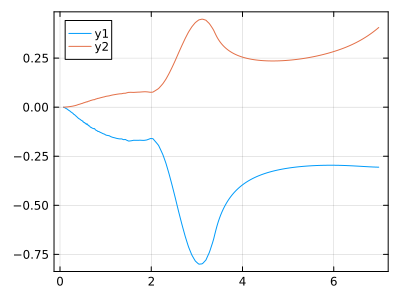

In [33]:
let index=4*mpi^2 .<spath_vec .<7.0
    tmp_arr=@. sinδ_absΩ_arr*Ftilde_arr_initial/κs(spath_vec)^3
    plot(spath_vec[index],real.(tmp_arr[index]))
    plot!(spath_vec[index],imag.(tmp_arr[index]))
end

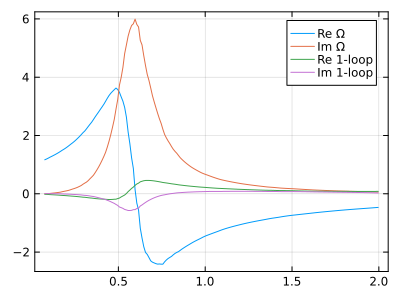

In [35]:
let sv=collect(4*mpi^2:0.01:2.0)
    resv=[disperfunc(s;Ft_arr=Ftilde_arr_initial) for s in sv]
    Ω1_arr=Ω1_all.(sv)
    plot(sv,real.(Ω1_arr),label="Re Ω")
    plot!(sv,imag.(Ω1_arr),label="Im Ω")
    plot!(sv,real.(resv),label="Re 1-loop")
    plot!(sv,imag.(resv),label="Im 1-loop")
end

In [37]:
Ftilde_iter=[zeros(ComplexF64,lens) for i in 1:5];

In [38]:
for i in 1:5
    println(i)
    KT_iteration!() 
    Ftilde_iter[i] .=Ftilde_arr
end

1
Processing the first integral...Processing the second integral...Processing the third integral...2
3rocessing the first integral...Processing the second integral...Processing the third integral...
Processing the first integral...Processing the second integral...Processing the third integral...4
5rocessing the first integral...Processing the second integral...Processing the third integral...
Processing the first integral...Processing the second integral...Processing the third integral...

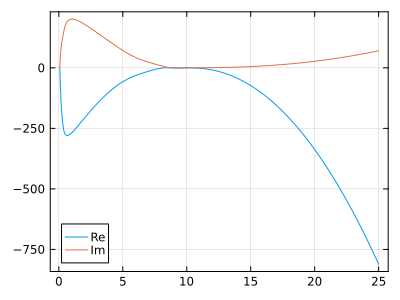

In [39]:
plot(spath_vec,real.(Ftilde_arr),label="Re");plot!(spath_vec,imag.(Ftilde_arr),label="Im")

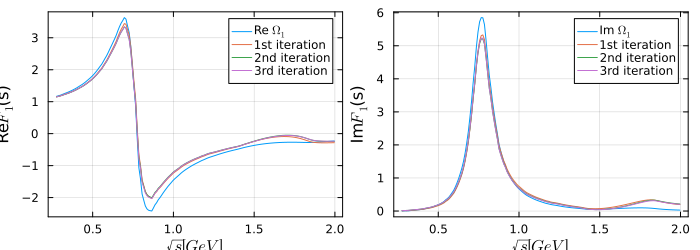

In [43]:
let Ev=collect(2*mpi:0.01:2.0)
    Ω1_arr=Ω1_all.(Ev .^2)
    resv1=@. Ω1_arr+[disperfunc(e^2;Ft_arr=Ftilde_iter[1]) for e in Ev]
    resv2=@. Ω1_arr+[disperfunc(e^2;Ft_arr=Ftilde_iter[2]) for e in Ev]
    resv3=@. Ω1_arr+[disperfunc(e^2;Ft_arr=Ftilde_iter[3]) for e in Ev]
    resv4=@. Ω1_arr+[disperfunc(e^2;Ft_arr=Ftilde_iter[4]) for e in Ev]
    resv5=@. Ω1_arr+[disperfunc(e^2;Ft_arr=Ftilde_iter[5]) for e in Ev]
    plt1=plot(Ev,real.(Ω1_arr),label=L"Re $Ω_1$",xlabel=L"\sqrt{s}[GeV]",ylabel=L"Re$F_1$(s)")
    plot!(Ev,real.(resv1),label="1st iteration")
    plot!(Ev,real.(resv2),label="2nd iteration")
    plot!(Ev,real.(resv3),label="3rd iteration")
    # plot!(Ev,real.(resv4),label="4th iteration")
    # plot!(Ev,real.(resv5),label="5th iteration")
    plt2=plot(Ev,imag.(Ω1_arr),label=L"Im $Ω_1$",xlabel=L"\sqrt{s}[GeV]",ylabel=L"Im$F_1$(s)")
    plot!(Ev,imag.(resv1),label="1st iteration")
    plot!(Ev,imag.(resv2),label="2nd iteration")
    plot!(Ev,imag.(resv3),label="3rd iteration")
    # plot!(Ev,imag.(resv4),label="4th iteration")
    # plot!(Ev,imag.(resv5),label="5th iteration")
    plot(plt1,plt2,layout=(1,2),size=(700,250))
end

In [44]:
JLD.save("./output/KT_Ftilde_P_1sub.jld","Ftilde_mat",Ftilde_iter);

### Excuting only for 2 subtractions

In [26]:
Ftilde_arr_initial_a=zeros(ComplexF64,lens);
Ftilde_arr_initial_b=zeros(ComplexF64,lens);

In [27]:
for i in 1:lens
    s=spath_vec[i]
    Σ0=mJψ^2+3*mpi^2
    κs0=κs(s)
    temp_arr=(@. κs0^2-(2*spath_curve[lens-i+1:lens+i]-Σ0+s)^2)
    Ftilde_arr_initial_a[i]=3*NumericalIntegration.integrate(spath_curve[lens-i+1:lens+i],temp_arr .*Ω1_arr_curve[lens-i+1:lens+i])
    Ftilde_arr_initial_b[i]=3*NumericalIntegration.integrate(spath_curve[lens-i+1:lens+i],temp_arr .*Ω1_arr_curve[lens-i+1:lens+i] .*spath_curve[lens-i+1:lens+i])
end

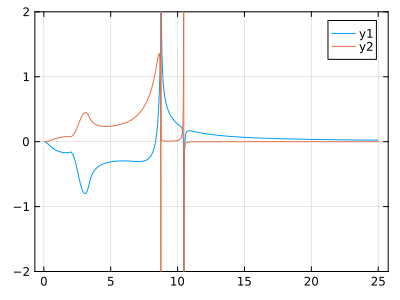

In [33]:
let index=4*mpi^2 .<spath_vec .<25.0
    tmp_arr=@. sinδ_absΩ_arr*Ftilde_arr_initial_a/κs(spath_vec)^3
    plot(spath_vec[index],real.(tmp_arr[index]),ylims=(-2,2))
    plot!(spath_vec[index],imag.(tmp_arr[index]))
end

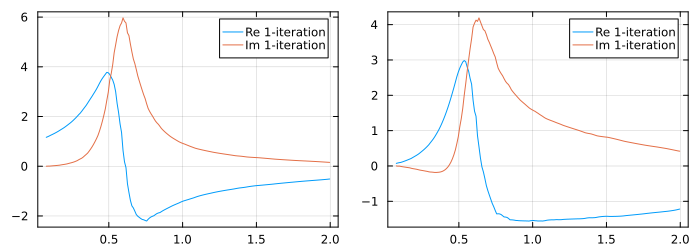

In [28]:
let sv=collect(4*mpi^2:0.01:2.0),nsub=2,rtol=1e-2
    resv1=[disperfunc(s;nsub=nsub,Ft_arr=Ftilde_arr_initial_a,rtol=rtol) for s in sv]
    resv2=[disperfunc(s;nsub=nsub,Ft_arr=Ftilde_arr_initial_b,rtol=rtol) for s in sv]
    Ω1_arr=Ω1_all.(sv)
    
    plt1=plot(sv,real.(Ω1_arr .+resv1),label="Re 1-iteration")
    plot!(sv,imag.(Ω1_arr .+resv1),label="Im 1-iteration")
    plt2=plot(sv,real.(@. (Ω1_arr*sv +resv2)),label="Re 1-iteration")
    plot!(sv,imag.(@. (Ω1_arr*sv +resv2)),label="Im 1-iteration")
    
    plot(plt1,plt2,layout=(1,2),size=(700,250))
end

In [29]:
Ftilde_iter_a=[zeros(ComplexF64,lens) for i in 1:10];
Ftilde_iter_b=[zeros(ComplexF64,lens) for i in 1:10];

In [ ]:
for i in 1:2
    println(i)
    KT_iteration!(;nsub=2,Ft_arr_init=Ftilde_arr_initial_a,Ft_arr=Ftilde_arr,ϵ=1.0e-8,rtol=1e-2) 
    Ftilde_iter_a[i] .=Ftilde_arr
end

1
Processing the first integral...Processing the second integral...